<a href="https://colab.research.google.com/github/ryanheminway/LearningInTheGym/blob/main/Final_DQL_Lunar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install box2d-py
!pip install gymnasium
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the l

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from statistics import mean
import numpy as np
import pandas as pd
import random
import sys
from collections import deque, defaultdict, namedtuple
import copy

import gymnasium as gym

In [ ]:
# Set random seeds  for reproducable results
SEED = 0
if SEED is not None:
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    print(f"Random Seed: {SEED}")

#Set where computations happen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set Environments
env_name = 'LunarLander-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name, render_mode="human")
    
######HYPERPARAMS########
NUM_ACTIONS = env.action_space.n
STATE_DIM = env.observation_space.shape[0]


# Sizes of the hidden layers in the neural network
HL1_SIZE = 64

# Experience Replay related params
REPLAY_SIZE = 100_000 # Max Size of buffer
MIN_MEMORY_SIZE = 1000 #Minimum amount of experiences needed before sampling/updates begin

EVAL_EPISODES = 25
TRAINING_LOOPS = 100
MAX_EPISODES = 2000
MAX_EPISODE_LENGTH = 1500
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4 # * 5
UPDATE_RATE = 50 #The rate of overwritting the target network with the main network
MAIN_UPDATE_PERIOD = 4  #Number of actions chosen using main network before it is updated (reduce instability) 
EVAL_PERIOD = 50  #How often to evaluate 

In [ ]:
##Set Up Classes##

class DQNet(nn.Module):
    
    def __init__(self, stateDim, actionDim):
        super().__init__()
        
        #Hidden Layer 1
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=stateDim, out_features=HL1_SIZE),
            nn.ReLU(True))

        #Output Layer
        #No activation function because we are estimating Q values
        self.fcOutput = nn.Linear(in_features = HL1_SIZE, out_features = actionDim)  
        
    def forward(self, x):
        
        """Forward Pass"""
        
        out = self.fc1(x)
        out = self.fcOutput(out)
        
        return out 

    
class ReplayMemory(object):
    
    def __init__(self, replaySize, batchSize):

        self.batchSize = batchSize
        self.memory = deque(maxlen = replaySize)
        self.experience = namedtuple("Experience", 
                                     field_names=["State", "Action", "NextState", "Reward"])

    def addExperience(self, state, action, nextState, reward):
        
        experience = self.experience(state, action, nextState, reward)
        self.memory.append(experience)
                
    def sample(self):
        
        batchSize = min(self.batchSize, len(self))
        return random.sample(self.memory, batchSize)
                
    def __len__(self):
        return len(self.memory)



class Agent:
    
    def __init__(self, stateSize, numActions):

        
        self.stateSize = stateSize
        self.numActions = numActions
    
        self.netPolicy = DQNet(stateSize, numActions).to(device)
        
        self.netTarget = DQNet(stateSize, numActions).to(device)
        self.netTarget.load_state_dict(self.netPolicy.state_dict()) 
        
        self.optimizer = optim.Adam(self.netPolicy.parameters(), lr = LR)
        self.loss = nn.MSELoss()
        
        self.memory = ReplayMemory(REPLAY_SIZE, BATCH_SIZE)    

        self.numUpdates = 0
        
    

    def update(self):
        
        batch = self.memory.sample()

        states = [experience.State for experience in batch]
        states = torch.tensor(states, dtype=torch.float32, device=device)
        
        actions = [experience.Action for experience in batch]
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        
        actions = actions.unsqueeze(1).to(device)
        

        rewards = [experience.Reward for experience in batch]
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        
        # If the nextState in ReplayMemory is None, then replace it with a vector of zeros
        nextStates = [[0] * STATE_DIM if experience.NextState is None else experience.NextState
                      for experience in batch]
        nextStates = torch.tensor(nextStates, dtype=torch.float32, device=device)
        noNextStateFilter = torch.tensor([experience.NextState is not None for experience in batch],
                                         dtype=torch.int)

        
        with torch.no_grad():
            
            self.netTarget.eval()
            allTargetQVals = self.netTarget(nextStates)
            # maxTargetQVals should be 0 if terminal state
            maxTargetQVals = allTargetQVals.max(dim=1)[0] * noNextStateFilter
            
        trueQVals = rewards + (GAMMA * maxTargetQVals )
        trueQVals = trueQVals.unsqueeze(1) #make it a a 2-d tensor of shape: (numrow = BATCH_SIZE, numcol = 1) 
        
        
        
        
        self.netPolicy.train()
        allQVals = self.netPolicy(states)
        # Generate all Q values (Qvalue of every action for a given state)
        
        # Only keep the qvalues that correspond to the action which was actually experienced
        predictedQVals = torch.gather(input = allQVals, dim = 1, index = actions)

        loss = self.loss(predictedQVals, trueQVals)

        self.optimizer.zero_grad()
        loss.backward()
        
        ## Gradient clipping for training stability (clip all the gradients greater than 3)
        # nn.utils.clip_grad_norm_(self.netPolicy.parameters(), 3)
        
        self.optimizer.step()
            
        self.numUpdates += 1
        
        if self.numUpdates % UPDATE_RATE == 0:
            #print(f"Update: {self.numUpdates} - Overriding Target Network...") 
            self.netTarget.load_state_dict(self.netPolicy.state_dict()) 
            
    
    # While evaluating a policy (as opposed to while training) act greedily
    def act_epsilon_greedy(self, state, epsilon, evaluate=False):
        if epsilon > 1 or epsilon < 0:
            raise Exception('Value of epsilon must be between 0 and 1')

        with torch.no_grad():
            self.netPolicy.eval()
            state = torch.tensor(state, dtype=torch.float32) 
            out = self.netPolicy(state)

        maxAction = int(out.argmax())

        if not evaluate and random.random() < epsilon:
            # While exploring sample uniformly from all actions, including the max-action
            action = random.choice(range(NUM_ACTIONS))

        else:
            # While exploiting or during policy evaluation, choose the greedy action
            action = maxAction

        return action
    

    def learn(self, state, action, nextState, reward):
        
        self.memory.addExperience(state, action, nextState, reward)


In [ ]:
# Epsilon-related params
EPSILON = 1.0  #Initial Epsilon Value (action choice is random)
EPSILON_DECAY = 0.99999  #Epsilon Decay Rate
EPSILON_MIN = 0.01  #Minimum Epsilon Value (1% chance of sampling random action)

##Training##
def run_agent_in_env(env, agent, train=False, sparse=False):
  global EPSILON, MAX_EPISODE_LENGTH, MIN_MEMORY_SIZE, EPSILON_MIN, EPSILON_DECAY, MAIN_UPDATE_PERIOD
  """
  Evaluate a given agent in a given environment. Tracks total reward and number
  of steps in environment. The "train" parameter is useful for indicating 
  whether this run is used for training or evaluation. The "sparse" parameter 
  will turn any given Gym environment into a "sparse" version of the same
  environment. In RL, a sparse environment is one in which reward is only given 
  at the terminal state. 
  """
  score = 0
  steps = 0
  terminated = False

  state, _ = env.reset()
  while not terminated and steps < MAX_EPISODE_LENGTH:
    # Use epsilon_greedy policy if we are not training
    action = agent.act_epsilon_greedy(state, EPSILON, evaluate=(not train))
    nextState, reward, terminated, truncated , info = env.step(action)

    if terminated:
        # On termination the nextState is a vector of floating number representing
        # the state of the environment. So, make the nextState 'None' explicitly
        nextState = None
            
    score += reward
    steps += 1

    if (train):
      # When training, allow agent to remember experiences
      if (sparse):
        # If it is a sparse envrionment, reward is only at terminal state
        if (terminated):
          # At terminal state, provide total reward
          agent.learn(state, action, nextState, score)
        else:
          agent.learn(state, action, nextState, 0)
      else:
        # In non-sparse, provide step-reward
        agent.learn(state, action, nextState, reward)

      # When training, allow agent to learn from rewards
      if len(agent.memory) > MIN_MEMORY_SIZE:
        # Decay exploration parameter Ɛ over time to a minimum of EPSILON_MIN:
        # Ɛₜ = Ɛ*(decay)ᵗ
        if EPSILON > EPSILON_MIN:
          EPSILON *= EPSILON_DECAY
            
        if steps % MAIN_UPDATE_PERIOD == 0:   
          agent.update()

    # Always track next state     
    state = nextState 
  return score, steps, agent

# MOUNT GOOGLE DRIVE SO WE CAN EXPORT CSV RESULTS
from google.colab import drive
drive.mount('/drive')
drive_path = '/drive/My Drive/Colab Notebooks/'

# Train a model TRAINING_LOOPS separate times to build statistical significance 
for i in range(TRAINING_LOOPS):
  # Reset Epsilon for new training
  EPSILON = 1.0

  df = pd.DataFrame(columns=['Episode', 'Eval', 'TotalReward', 'NumSteps', 'Success', 'Epsilon'])
  df_name = drive_path + "{env}QDL_RUN={run}.csv".format(env=env_name, run=i)
  
  currentEpisode = 1
  scoresList = []
  epi_len_list = list()
  agent = Agent(stateSize = STATE_DIM, numActions = NUM_ACTIONS)

  agentsList = []

  state, _ = env.reset(seed=SEED)

  while currentEpisode < MAX_EPISODES + 1:
    runReward, steps, agent = run_agent_in_env(env, agent, train=True, sparse=False)
                
    # Evaluate current policy by number of episodes (vs by number of updates)
    if currentEpisode % EVAL_PERIOD == 0:
      for j in range(EVAL_EPISODES):
        evalScore, evalSteps, evalAgent = run_agent_in_env(env, agent, train=False)
        df = pd.concat([df, pd.DataFrame.from_records([{'Episode': currentEpisode,
                                                        'Eval': j, 
                                                        'TotalReward': evalScore,
                                                        'Success': str((evalScore > 200)),
                                                        'NumSteps': evalSteps,
                                                        'Epsilon' : EPSILON}])], ignore_index=True)
        # This will save to google drive
        df.to_csv(df_name)
        

      # Duplicating some of this tracking so we can write to file
      tempAgent = copy.deepcopy(agent)
      agentsList.append(tempAgent)
    
    scoresList.append(runReward)
    epi_len_list.append(steps)

    print(f"Episode: {currentEpisode} - Score: {runReward} - Length: {steps} - " +
          f"Epsilon: {EPSILON}")
    currentEpisode += 1 
        
    state, _ = env.reset()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Episode: 1 - Score: -168.88982969597743 - Length: 108 - Epsilon: 1.0
Episode: 2 - Score: -131.2645188259747 - Length: 85 - Epsilon: 1.0
Episode: 3 - Score: -117.20884459651265 - Length: 69 - Epsilon: 1.0
Episode: 4 - Score: -226.47257240727885 - Length: 84 - Epsilon: 1.0
Episode: 5 - Score: -112.22975165871694 - Length: 123 - Epsilon: 1.0
Episode: 6 - Score: -73.22080648848579 - Length: 86 - Epsilon: 1.0
Episode: 7 - Score: -125.76742109089474 - Length: 67 - Epsilon: 1.0
Episode: 8 - Score: -110.82989125479378 - Length: 116 - Epsilon: 1.0
Episode: 9 - Score: -134.14488243244344 - Length: 88 - Epsilon: 1.0
Episode: 10 - Score: -269.5551808457742 - Length: 78 - Epsilon: 1.0
Episode: 11 - Score: -129.03966729815528 - Length: 95 - Epsilon: 1.0


<ipython-input-6-60b1a0155c7f>:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.tensor(states, dtype=torch.float32, device=device)


Episode: 12 - Score: -100.92047679283053 - Length: 73 - Epsilon: 0.9992802555403735
Episode: 13 - Score: -271.936635218578 - Length: 117 - Epsilon: 0.9981117754931088
Episode: 14 - Score: -17.70506675822992 - Length: 72 - Epsilon: 0.9973933900726099
Episode: 15 - Score: -232.78926539488424 - Length: 84 - Epsilon: 0.9965559272212724
Episode: 16 - Score: -192.26558659229573 - Length: 73 - Epsilon: 0.9958287032273313
Episode: 17 - Score: -152.33988625838754 - Length: 77 - Epsilon: 0.9950622064324973
Episode: 18 - Score: -121.86269919258032 - Length: 72 - Epsilon: 0.9943460159224342
Episode: 19 - Score: -95.09799383304717 - Length: 85 - Epsilon: 0.9935011766922399
Episode: 20 - Score: -122.72570910537141 - Length: 78 - Epsilon: 0.9927265440472598
Episode: 21 - Score: -400.2588858876915 - Length: 154 - Epsilon: 0.9911989141082365
Episode: 22 - Score: -300.81561263984327 - Length: 80 - Epsilon: 0.9904062681143891
Episode: 23 - Score: -110.64215361657088 - Length: 76 - Epsilon: 0.989653841546

KeyboardInterrupt: ignored

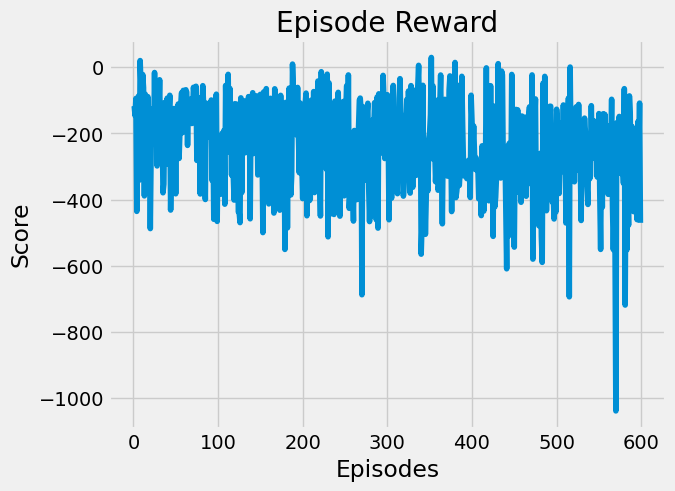

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.plot(range(1, 599 + 1), scoresList)
plt.title('Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

In [1]:
plt.plot(range(1, MAX_EPISODES + 1), epi_len_list)
plt.title('Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Length')
plt.show()

NameError: ignored

In [ ]:
# Evaluate each agent
eval_scores = []
eval_ep_lengths = []

NUM_EVAL = 10

for agent in agentsList:
    
    scores = []
    lengths = []
    
    #print(agent.numUpdates)
    
    for i in range(NUM_EVAL):
        
        eval_score = 0
        eval_episode_length = 0
        terminated = False

        state, _ = env.reset()
        while not terminated and eval_episode_length < MAX_EPISODE_LENGTH:
            action = agent.act_epsilon_greedy(state, EPSILON, evaluate=True)
            nextState, reward, terminated, truncated , info = env.step(action)
            state = nextState       
            eval_score += reward
            eval_episode_length += 1
            
        scores.append(eval_score)
        lengths.append(eval_episode_length)
        
    eval_scores.append(mean(scores))
    eval_ep_lengths.append(mean(lengths))

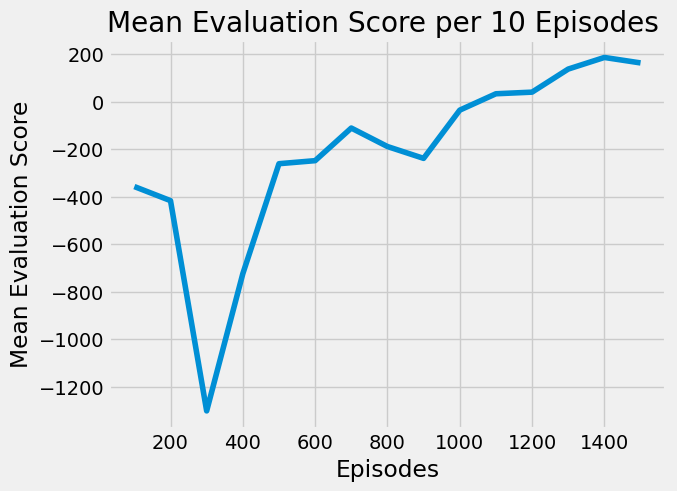

In [ ]:
plt.plot([i*100 for i in list(range(1, len(agentsList) + 1))], eval_scores)
plt.title('Mean Evaluation Score per 10 Episodes ')
plt.xlabel('Episodes')
plt.ylabel('Mean Evaluation Score')
plt.show()

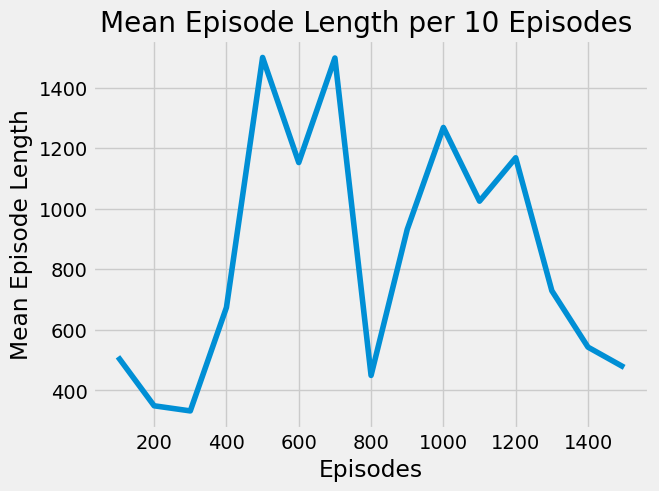

In [ ]:
plt.plot([i*100 for i in list(range(1, len(agentsList) + 1))], eval_ep_lengths)
plt.title('Mean Episode Length per 10 Episodes ')
plt.xlabel('Episodes')
plt.ylabel('Mean Episode Length')
plt.show()

In [ ]:
import pygame

eval_env = gym.make('LunarLander-v2', render_mode="human")


state, _ = eval_env.reset()
while not terminated and eval_episode_length < MAX_EPISODE_LENGTH:
    action = agent.act_epsilon_greedy(state, EPSILON, evaluate=True)
    nextState, reward, terminated, truncated , info = eval_env.step(action)
    state = nextState       
    eval_score += reward
    eval_episode_length += 1
    
pygame.quit()